- используемый датасет: Hearts Desease (https://archive.ics.uci.edu/dataset/45/heart+disease)

#Autoencoder

##Declare required dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

from ucimlrepo import fetch_ucirepo

In [17]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ['edible', 'poisonous']

## Data ingestion

In [4]:
gribiSet = pd.read_csv('gribochki.csv')

## Data exploration

In [5]:
display(gribiSet)

,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-color,ring-type,habitat,season,mmCapDiameter,mmStemHeight,mmStemWidth,class
0,6.0,2.0,6.0,0.0,2.0,1.0,10.0,5.0,11.0,10.0,10.0,2.0,0.0,3.0,0.240155,0.499705,0.164469,1.0
1,6.0,2.0,6.0,0.0,2.0,0.0,10.0,5.0,11.0,10.0,10.0,2.0,0.0,2.0,0.261782,0.530366,0.175055,1.0
2,6.0,2.0,6.0,0.0,2.0,0.0,10.0,5.0,11.0,10.0,10.0,2.0,0.0,3.0,0.220949,0.524764,0.170725,1.0
3,2.0,3.0,1.0,0.0,2.0,1.0,10.0,5.0,11.0,10.0,10.0,5.0,0.0,3.0,0.222563,0.464917,0.153787,1.0
4,6.0,3.0,6.0,0.0,2.0,0.0,10.0,5.0,11.0,10.0,10.0,5.0,0.0,3.0,0.230148,0.487323,0.165528,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46944,5.0,7.0,11.0,0.0,3.0,2.0,2.0,2.0,8.0,11.0,11.0,1.0,0.0,0.0,0.012912,0.115861,0.059859,1.0
46945,2.0,7.0,11.0,0.0,3.0,2.0,2.0,2.0,8.0,11.0,11.0,1.0,0.0,0.0,0.014364,0.093750,0.052257,1.0
46946,5.0,7.0,11.0,0.0,3.0,2.0,2.0,2.0,8.0,11.0,11.0,1.0,0.0,2.0,0.014364,0.113797,0.061303,1.0
46947,2.0,7.0,11.0,0.0,3.0,2.0,2.0,2.0,8.0,11.0,11.0,1.0,0.0,2.0,0.013880,0.104953,0.052353,1.0


In [6]:
gribiSet.describe()

,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-color,ring-type,habitat,season,mmCapDiameter,mmStemHeight,mmStemWidth,class
count,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000,46949.000000
mean,4.006539,5.483077,6.134146,0.180451,2.530363,0.730772,7.369593,2.180451,6.615349,7.298452,6.388847,1.569639,0.651409,1.072462,0.105304,0.196368,0.114917,0.563910
std,2.196437,3.277637,3.115151,0.384567,1.960101,0.786009,3.146798,0.865684,3.363683,3.249213,3.173705,1.649442,1.262806,1.108472,0.092782,0.106822,0.101915,0.495904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,5.000000,0.000000,1.000000,0.000000,5.000000,2.000000,4.000000,5.000000,5.000000,1.000000,0.000000,0.000000,0.049064,0.135613,0.047252,0.000000
50%,5.000000,7.000000,5.000000,0.000000,3.000000,1.000000,7.000000,2.000000,8.000000,9.000000,5.000000,1.000000,0.000000,1.000000,0.088767,0.176002,0.092388,1.000000
75%,6.000000,8.000000,10.000000,0.000000,4.000000,1.000000,10.000000,2.000000,9.000000,10.000000,10.000000,1.000000,1.000000,2.000000,0.132989,0.229658,0.155423,1.000000
max,6.000000,10.000000,11.000000,1.000000,6.000000,2.000000,11.000000,5.000000,11.000000,11.000000,11.000000,7.000000,6.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
gribiSet.isnull().values.any()  #есть ли пропуски?

False

## Class distribution

In [9]:
import pandas as pd

# Предположим, ваш DataFrame называется df, и в нем есть столбец 'class'
# df = pd.read_csv('ваш_датасет.csv')  # загрузите ваш датасет, если он еще не загружен

# Подсчет количества примеров в каждом классе
class_counts = gribiSet['class'].value_counts()
print(class_counts)

# Определение количества, до которого мы будем уменьшать класс с большим числом
num_to_select = class_counts.min()  # это количество для классирования

# Случайный выбор из класса с большим количеством
df_class_0 = gribiSet[gribiSet['class'] == 0.0]
df_class_1 = gribiSet[gribiSet['class'] == 1.0].sample(num_to_select, random_state=42)  # random_state для воспроизводимости

# Объединение обоих классов в новый DataFrame
balancedGribiSet = pd.concat([df_class_0, df_class_1])

# Перемешивание строк для случайного порядка
balancedGribiSet = balancedGribiSet.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверка результатов
print(balancedGribiSet['class'].value_counts())

# Сохранение в новый CSV файл (опционально)
# balanced_df.to_csv('balanced_dataset.csv', index=False)


class
1.0    26475
0.0    20474
Name: count, dtype: int64
class
1.0    20474
0.0    20474
Name: count, dtype: int64


C:\Users\max6k\AppData\Local\Temp\ipykernel_17296\2012142152.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(balancedGribiSet['class'], sort = True)


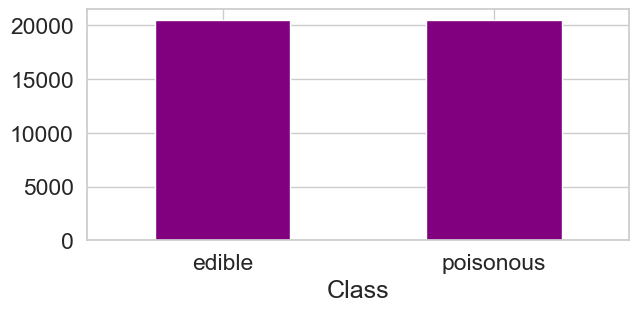

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))

count_classes = pd.value_counts(balancedGribiSet['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color='purple', ax = ax)
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.show()

In [ ]:
heartDF = df[df.num == 1]   #есть вероятность заболевания
normalDF = df[df.num == 0]  #нет вероятности

In [ ]:
heartDF.chol.mean()

252.73125

In [ ]:
normalDF.chol.mean()

243.49375

In [ ]:
heartDF.thalach.describe()

,thalach
count,160000.000000
mean,138.912500
std,22.816838
min,71.000000
25%,124.000000
50%,142.000000
75%,157.000000
max,195.000000


In [ ]:
normalDF.thalach.describe()

,thalach
count,160000.00000
mean,158.58125
std,18.98376
min,96.00000
25%,149.00000
50%,161.00000
75%,172.00000
max,202.00000


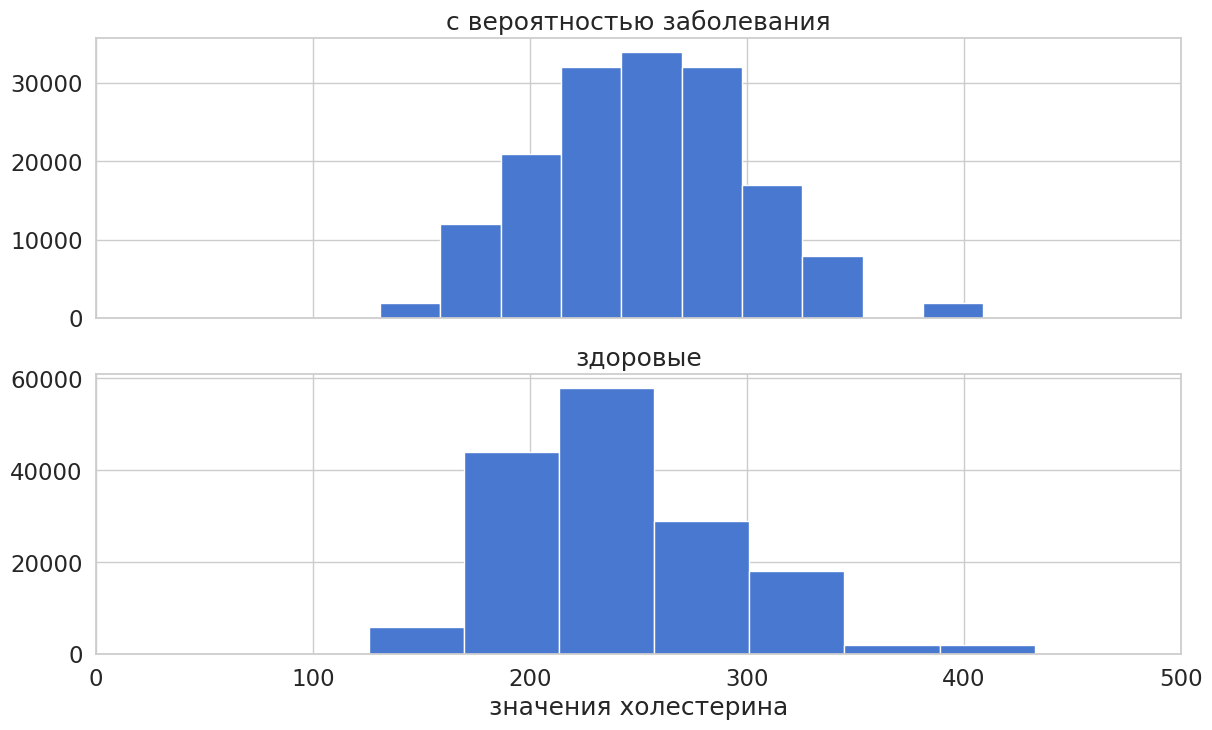

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.hist(heartDF.chol)
ax1.set_title('с вероятностью заболевания')

ax2.hist(normalDF.chol)
ax2.set_title('здоровые')

plt.xlabel('значения холестерина')
plt.xlim((0, 500))
plt.show();

Обе группы имеют схожие пики в диапазоне 200-300, что указывает на то, что уровень холестерина в этом диапазоне является наиболее распространенным как среди здоровых пациентов, так и среди тех, кто имеет вероятность заболевания.
Здоровые пациенты демонстрируют более широкий диапазон значений холестерина, включая более высокие значения, что может указывать на то, что уровень холестерина сам по себе не является единственным фактором, определяющим риск сердечно-сосудистых заболеваний

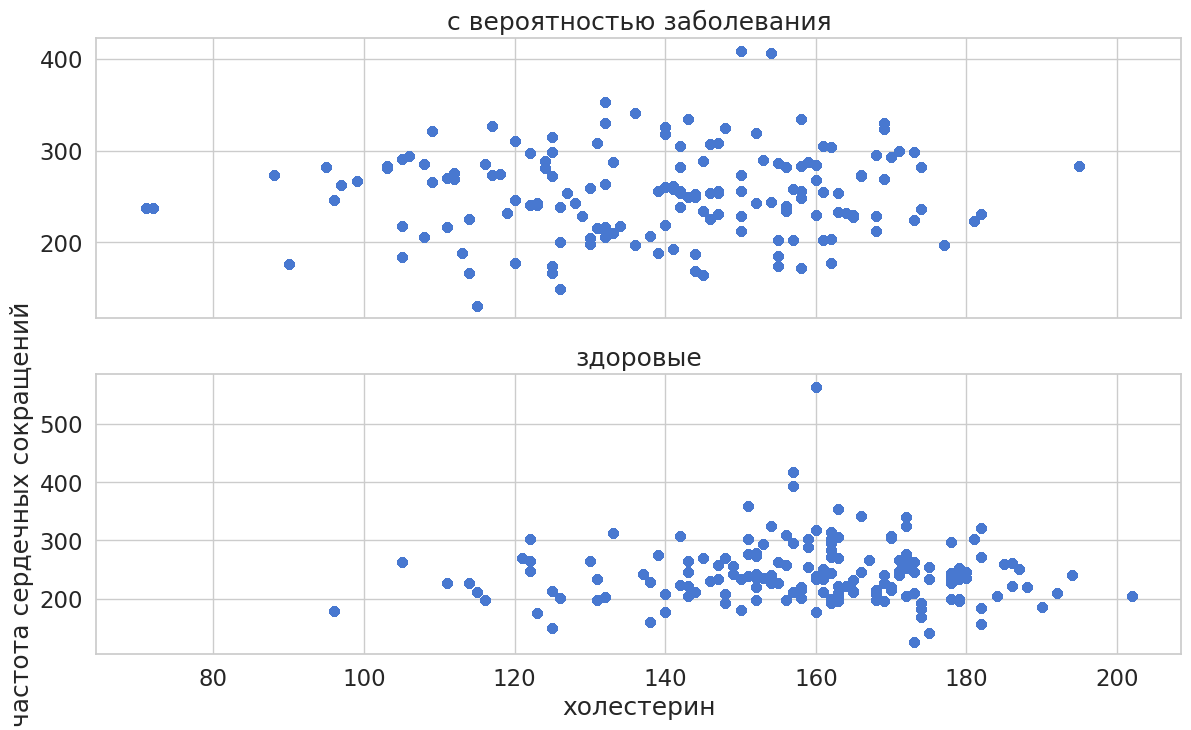

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.scatter(heartDF.thalach, heartDF.chol)
ax1.set_title('с вероятностью заболевания')

ax2.scatter(normalDF.thalach, normalDF.chol)
ax2.set_title('здоровые')

plt.xlabel('холестерин')
plt.ylabel('частота сердечных сокращений')
plt.show()

## Preprocessing

стандартизация данных

In [ ]:
#df['chol'] = StandardScaler().fit_transform(df['chol'].values.reshape(-1, 1))

In [ ]:
cols = df.columns
cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal']

In [ ]:
scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.944214,0.703795,-2.273366,0.754607,-0.296190,2.472066,1.003382,0.054066,-0.679108,1.097474,2.307547,-0.754459,0.629684,0
1,1.396025,0.703795,0.880436,1.614762,0.742559,-0.404520,1.003382,-1.758017,1.472521,0.393709,0.670263,2.483485,-0.937761,1
2,1.396025,0.703795,0.880436,-0.678985,-0.374587,-0.404520,1.003382,-0.851976,1.472521,1.361386,0.670263,1.404170,1.152166,1
3,-1.992557,0.703795,-0.170831,-0.105548,0.036993,-0.404520,-1.028784,1.650425,-0.679108,2.153123,2.307547,-0.754459,-0.937761,0
4,-1.540746,-1.420869,-1.222098,-0.105548,-0.864563,-0.404520,1.003382,1.003252,-0.679108,0.305738,-0.967021,-0.754459,-0.937761,0


### Разделите набор данных на наборы обучающих и тестовых данных.

 набор данных как обучение = 80% и тест = 20%
 в обучающем наборе данных будут только здоровые, а в тестовом наборе данных будут все

In [19]:
X_train, X_test = train_test_split(balancedGribiSet, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train['class'] == 0]
X_train = X_train.drop(['class'], axis=1)

y_test = X_test['class']
X_test = X_test.drop(['class'], axis=1)

X_train = X_train.values

X_test = X_test.values
y_test = y_test.values
print(y_test.size)

8190


In [32]:
print(balancedGribiSet.shape)

(40948, 18)


## Model

автоэнкодер, состоящий из 4 полносвязных слоев с 13, 8, 4, 13 нейронами.
Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер

последний слой имеет 13 узлов, соответствующих 13 функциям в элементе входных данных.

In [33]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #кодирующий слой
        self.encoder = nn.Sequential(
            nn.Linear(17, 8),
            nn.Tanh(),
            nn.Linear(8, 4),
            nn.LeakyReLU(),
            )

        #декодирующий
        self.decoder = nn.Sequential(
           nn.Linear(4, 8),
           nn.Tanh(),
           nn.Linear(8, 17),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
model = Autoencoder().double()

In [35]:
num_epochs = 150   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей/векторов, которые передаются в наш алгоритм обучения.

Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик. По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.

**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [36]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [37]:
#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [39]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

- Проходит определенное количество эпох.
- На каждой эпохе проходит через весь обучающий набор данных с расчетом потерь.
- Производится обновление параметров модели с использованием методов обратного распространения.
- В конце сохраняются веса обученной модели для дальнейшего использования.

In [40]:
if np.any(np.isnan(balancedGribiSet)) or np.any(np.isinf(balancedGribiSet)):
    print("Данные содержат nan или inf значения.")

In [41]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/150], loss:11.6491
epoch [2/150], loss:4.7897
epoch [3/150], loss:3.7744
epoch [4/150], loss:3.3810
epoch [5/150], loss:2.8417
epoch [6/150], loss:2.3289
epoch [7/150], loss:2.0167
epoch [8/150], loss:1.8109
epoch [9/150], loss:1.6032
epoch [10/150], loss:1.4066
epoch [11/150], loss:1.2733
epoch [12/150], loss:1.1895
epoch [13/150], loss:1.1384
epoch [14/150], loss:1.1065
epoch [15/150], loss:1.0854
epoch [16/150], loss:1.0708
epoch [17/150], loss:1.0596
epoch [18/150], loss:1.0520
epoch [19/150], loss:1.0459
epoch [20/150], loss:1.0409
epoch [21/150], loss:1.0372
epoch [22/150], loss:1.0337
epoch [23/150], loss:1.0309
epoch [24/150], loss:1.0271
epoch [25/150], loss:1.0249
epoch [26/150], loss:1.0221
epoch [27/150], loss:1.0198
epoch [28/150], loss:1.0169
epoch [29/150], loss:1.0152
epoch [30/150], loss:1.0131
epoch [31/150], loss:1.0112
epoch [32/150], loss:1.0097
epoch [33/150], loss:1.0082
epoch [34/150], loss:1.0067
epoch [35/150], loss:1.0052
epoch [36/150], loss:1.0034


Конечное значение ошибки (0.5648) указывает на то, что модель достаточно хорошо реконструирует входные данные.

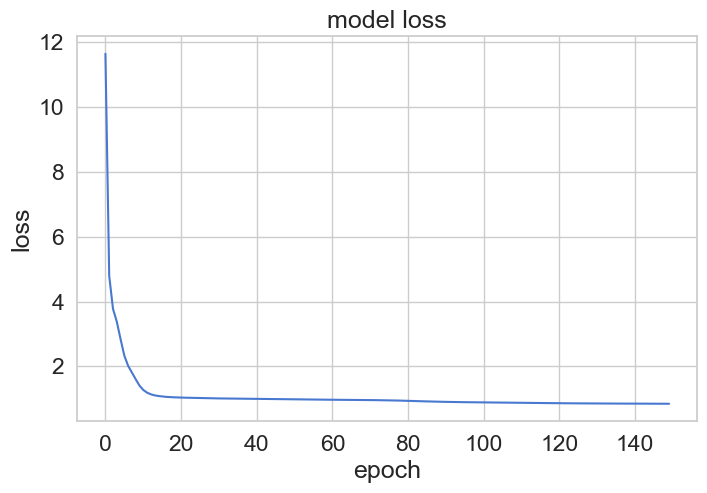

In [43]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.axis([0, 1, 0.69, 1])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

Быстрое снижение ошибки в начале обучения и её стабилизация в последующих эпохах указывают на то, что модель хорошо сходится.

## Оценка модели

In [46]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data

        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()

        pred_losses['pred_loss'].append(loss)

reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['class'] = y_test

In [47]:
reconstructionErrorDF.describe()

,pred_loss,class
count,8190.000000,8190.000000
mean,1.152933,0.496337
std,0.934495,0.500017
min,0.111692,0.000000
25%,0.470999,0.000000
50%,0.894487,0.000000
75%,1.516170,1.000000
max,7.212500,1.000000


Модель автоэнкодера показывает хорошие результаты в реконструкции входных данных, что подтверждается средним значением ошибки реконструкции.
Целевая переменная имеет примерно равномерное распределение классов, что указывает на сбалансированность данных.

# Reconstruction Errors without Fraud

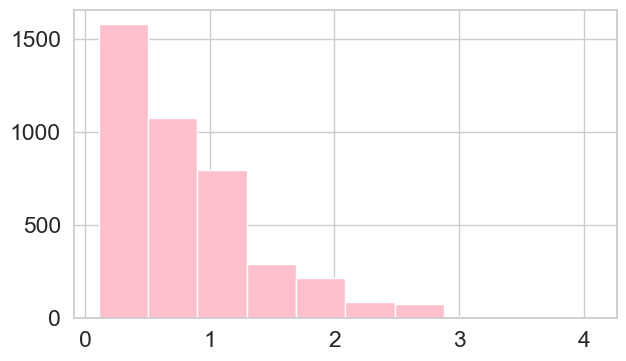

In [49]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10, color = 'pink')

Ошибки реконструкции больше 1.0 встречаются редко, что может указывать на наличие аномалий или выбросов в данных.
График подтверждает, что модель автоэнкодера хорошо справляется с реконструкцией данных для здоровых пациентов.

# Reconstruction Errors with Fraud

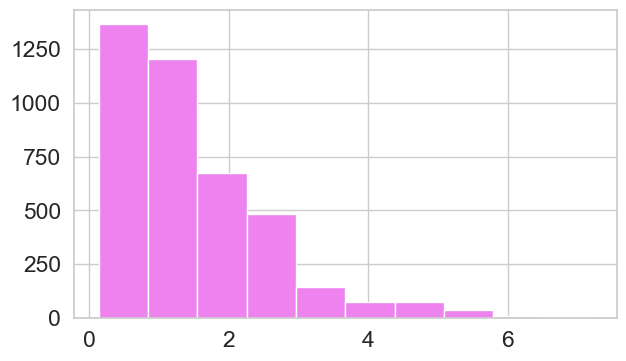

In [51]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10, color = 'violet')

График подтверждает, что модель автоэнкодера имеет более высокие ошибки реконструкции для пациентов с вероятностью заболевания, что может быть использовано для обнаружения аномалий.

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

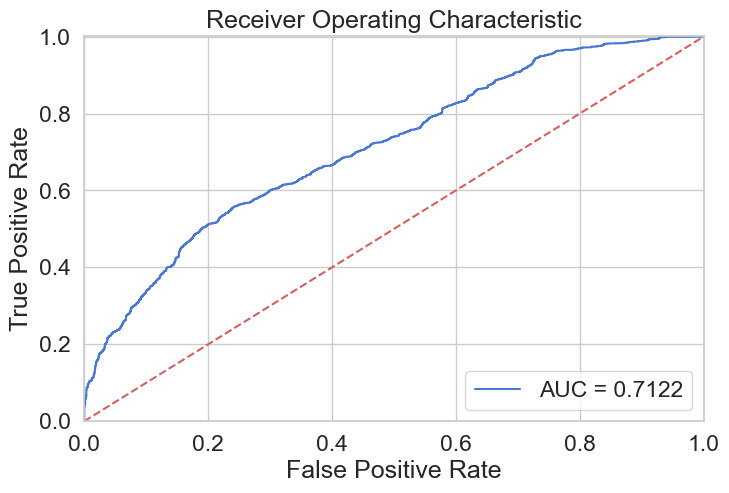

In [55]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF['class'], reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC-кривая и значение AUC подтверждают, что модель автоэнкодера эффективна в обнаружении вероятности заболевания сердечно-сосудистыми заболеваниями

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

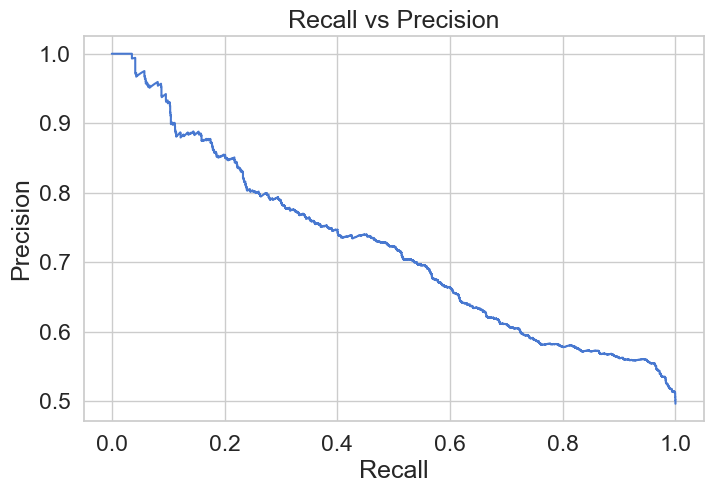

In [56]:
plt.figure(figsize=(8, 5))
precision, recall, th = precision_recall_curve(reconstructionErrorDF['class'], reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

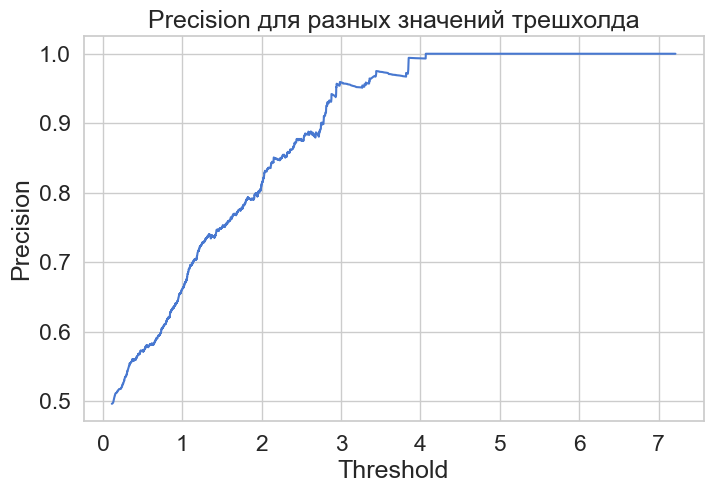

In [57]:
plt.figure(figsize=(8, 5))
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


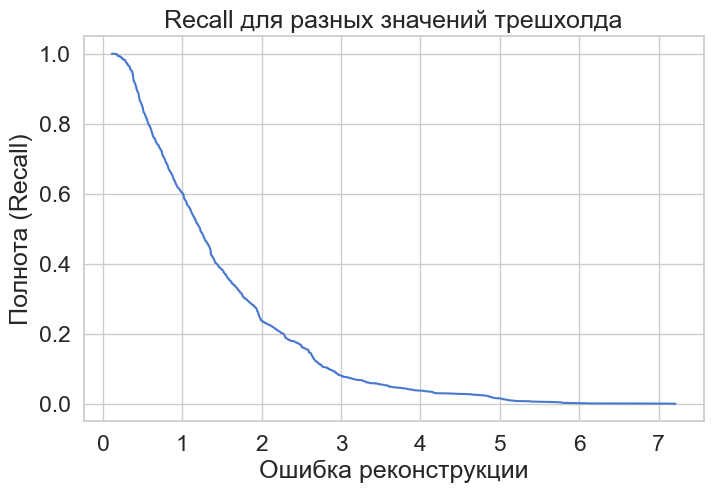

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

In [64]:
threshold = 2

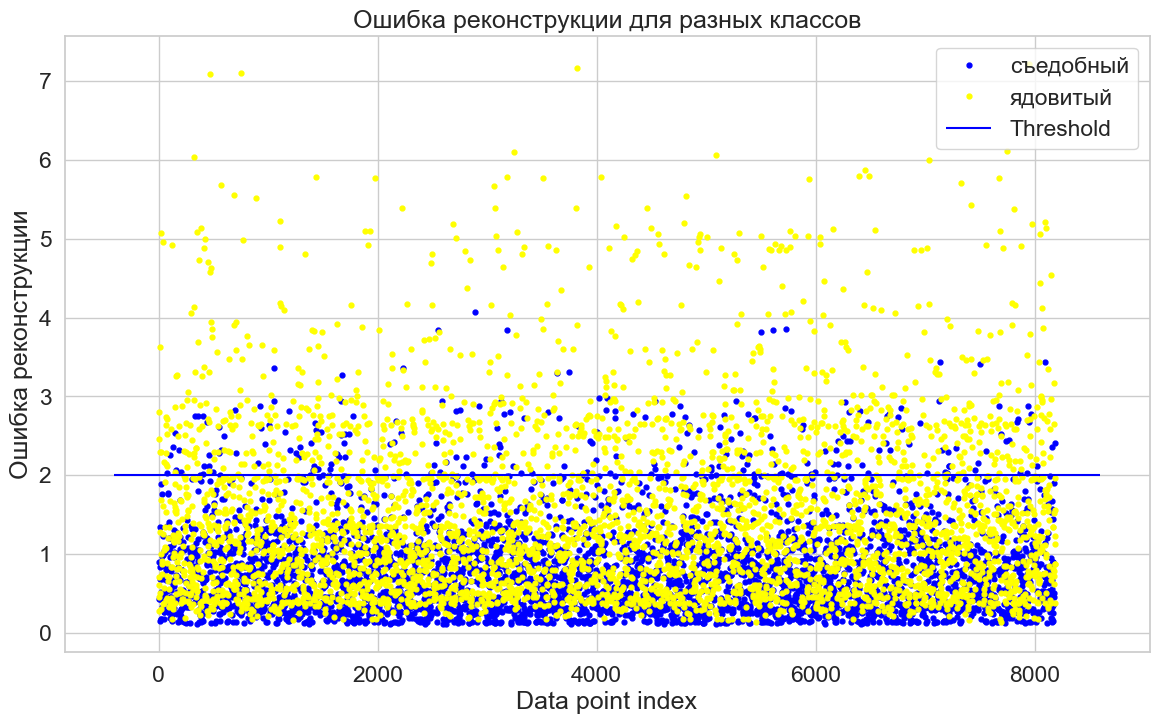

In [65]:
groups = reconstructionErrorDF.groupby('class')
fig, ax = plt.subplots()

colors = {1: 'yellow', 0: 'blue'}

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "ядовитый" if name == 1 else "съедобный", color=colors[name])
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="blue", zorder=100, label='Threshold')
ax.legend()

plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show()

C:\Users\max6k\AppData\Local\Temp\ipykernel_17296\3525006913.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Pastel1'))


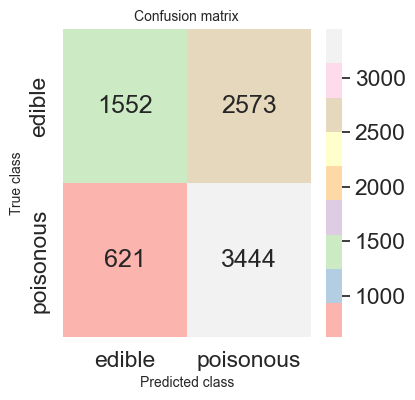

In [62]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF['class'], y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Pastel1'))
plt.title("Confusion matrix", size = 10)
plt.ylabel('True class', size = 10)
plt.xlabel('Predicted class', size = 10)
plt.show()

Учитывая сложности и неопределённости датасета, в котором дано немного сильно влияющих факторов, из-за которых действительно сложно определить ядовитость гриба, модель вполне неплохо смогла определить ядовитые грибы, что уже повышает шансы на выживание.
Ешьте шампиньоны.
